### Word embedding Skip Gram(NCS loss)

In this note book we walk through essential steps of building word embeddings(vector representation of words) form a given text data, using a popular algo called Skip gram. 

We start by importing the necessary libraries. 

In [1]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot
from sklearn.manifold import TSNE

This sample data is taken from Wiki, initial lines on word embedding page/first paragraph. 
We can do various kind preprocessing steps, like removing stop words, puntutations, remove unwanted characters, lowercasing etc.. all of these will get you a better representation of word as a vector, but also depends on the what you try to achive from your embeddings as such. 

In [2]:
DataRaw = "Understanding the meanings of words is an essential step for natural language processing NLP systems . In recent years there has been an immense interest in methods that learn word representations in an unsupervised manner from massive text collections . Such methods often represent the meanings of words in linear algebraic structures such as vectors that capture lexico semantic information about the word . The usefulness of such word embeddings has been demonstrated by their impressive performances in various NLP tasks such as name entity recognition word similarity measurement sentiment analysis word analogy detection syntactic parsing and dependency parsing . Moreover high quality embeddings of individual words can be used to build semantic representations for larger lexical units such as phrases sentences and documents in a bottom up manner by recursively applying semantic compositional operators on the word level embeddings ."
DataRaw = DataRaw.replace(",", "")

Create a list of unique words, which is used to creat word to integer and integer to word dictionaries. These dictionaries are used for feeding data to our place holders for training, accessing word embeds from lsit of embeds after training, creating one hot representation of the each word and for other computations. 

In [3]:
listOfAllWords = [word.lower() for word in DataRaw.split(" ")]
listOfAllWordsUnique = list(set(listOfAllWords))  

Create word2Int and int2Word dictionaries, each unique word is represented with a number. 

In [4]:
word2Int = {}
int2Word = {}

for idx, word in enumerate(listOfAllWordsUnique):
    word2Int[word] = idx
    int2Word[idx] = word

Create a list of list to prepare data for building our word embeddings , the inner list is comprised of words in each sentence and outer list is sentences, tokensing a sentence. 

In [5]:
sentences = []
for sentence in DataRaw.split("."):
    sentences.append(sentence.lower().split())

Training data for skip gram: 

Lets discus bit about skip gram data preparation for training.

our aim is to get the vector representation of target word (Wv) with respect to its sourounding words, lwts call it context words(Wc). We can chouse the radius of context words, by this I mean how many context words around our target word we consider, on both sides of target word. 

lets take a sample sentence : "Understanding the meanings of words is an essential step for natural language processing NLP systems"
with radius as 2, we can visualize data represented for our model as: 

Target_Word(Input) : 'language'
Context_words(Output) : ['for','natural','processing','NLP']

Training our model with single input and multiple output is practically difficult to implement. So we break down our data into several single tuples of input and output, (input:'language', output:'for'),(input:'language', output:'natural'),(input:'language', output:'processing'),(input:'language', output:'NLP'). If there is no context word out of predifined radius we ignore thouse data, target word at start or end of sentence, we only consider context word lining at the right and left of target word respectively. 

In [6]:
windowSize = 2
EmbeddingDimension = 2
NegativeSampleSize = 10
Data = []
for sentence in sentences:
    for idx1, word1 in enumerate(sentence):
        if idx1 >+ windowSize:
            for idx2, word2 in enumerate(sentence[idx1-windowSize:idx1+windowSize+1]):
                if word1 != word2:
                    Data.append([word1, word2])
        else:
            for idx3, word3 in enumerate(sentence[0:idx1+windowSize+1]):
                if word1 != word3:
                    Data.append([word, word3])

In [7]:
X_train = []
Y_train = []
vocabSize = len(listOfAllWordsUnique)
for wordlist in Data:
    tempX = []
    X_train.append(word2Int[wordlist[0]])
    Y_train.append(word2Int[wordlist[1]])
    
X_train = np.array(X_train)
Y_train = np.array(Y_train)
Y_train = Y_train.reshape(-1,1)

#### The model we are traninng is a softmax model (logistic multiclass model)

We start by defining the placeholders for input and output. Then embedding layer with dimension of vocabulary size and dimension of embedding word we intentend to. Then an embedding lookup is create as tensorflow doesn’t allow index lookup with Tensors.

We define weights of size vocabulary and dimension of embedding word and bias for our soflmax layer. After these initialization/definations we calculate loss/train our model using tensorflows nce_loss API. When we condiser these embeddings for practicle purposes like sentiment analysis, chatbot, language transulations we need sizeble amount of data, which invarably increase our vocabulary size to (~50000) or more. 


\begin{align}
\Pr( C \mid O ) = \frac {Exp(U_o^T V_c)} {\sum_{w=1}^v Exp(U_w^T V_c)}
\end{align}

softmax calculates the probability of a word 'O' given its context 'C', which can be computed using the following above equation. Where Uo is the context word and Vc is the target word/center word. V is the all unique words in our vocabulary. 

\begin{align}
J(\theta) = - {U_o^T V_c} + \log {\sum_{w=1}^v Exp(U_w^T V_c)}
\end{align}

Computing the softmax is expensive as the inner product between Vc and the output embedding of every word w in the vocabulary V needs to be computed,  to obtain the normalized probability. We can clearly see that this posses a challenge if our vocabulary size is large, which is true in all cases. So we employ a sampling based approache called Noice constructive estimation(NCE), which is proved to work better for most use cases.

In nutshell, we create a distribution (X), with our context word and some fixed number(k) of noice words(), which is similar to our data distribution (Z), with certain probability. This turns out to be a binary classification from multinomial i.e now model is trained to differentiate the target word from noise, so instead of calculating probability for all the words in our vocabulary, we only calculate for our context words and some fixed number of noise words. Now we our loss function for all the words in our vocalubary takes the form as shown in below equation, where the first element is the true class(y=1) and second is noise words(y=0). 

\begin{align}
J(\theta) = -{\sum_{w=1}^V{\log P(y=1|O,C)}} + {\sum_{i=1}^K{\log P(y=0|O,C_i)}}
\end{align}

In [8]:
X_placeholder = tf.placeholder(shape=[None], dtype=tf.int32)
y_placeholder = tf.placeholder(shape=[None,1], dtype=tf.int32)

In [9]:
embeddings = tf.Variable(tf.random_uniform([vocabSize, EmbeddingDimension],-1.0,1.0))
embed = tf.nn.embedding_lookup(embeddings, X_placeholder)

weights = tf.Variable(tf.truncated_normal([vocabSize, EmbeddingDimension],stddev=1.0/math.sqrt(EmbeddingDimension)))
bias = tf.Variable(tf.zeros([vocabSize]))

loss = tf.reduce_mean(tf.nn.nce_loss(weights=weights, biases=bias, labels=y_placeholder, inputs=embed, 
                                     num_sampled=NegativeSampleSize, num_classes=vocabSize))
optimizer = tf.train.AdamOptimizer(1e-1).minimize(loss)

norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
normalized_embeddings = embeddings / norm

In [10]:
# Saver 
saver = tf.train.Saver([embeddings])

The graph is defined, we now train our model and visualize using TSNE. 

In [11]:
epochs = 10000

sess = tf.Session()
sess.run(tf.global_variables_initializer())
saver.save(sess, './myTestEmbedding',global_step=1000)
for epoch in range(epochs):
    _, loss_val = sess.run([optimizer, loss], feed_dict={X_placeholder: X_train, y_placeholder: Y_train})
    
    if epoch % 2000==0:
        print("Epoch : ",epoch," loss is : ", loss_val)

Epoch :  0  loss is :  17.04415
Epoch :  2000  loss is :  2.6551576
Epoch :  4000  loss is :  2.6185057
Epoch :  6000  loss is :  1.9160986
Epoch :  8000  loss is :  2.5533159


In [12]:
Embeddings = sess.run(normalized_embeddings)
sess.close()

In [13]:
tsne = TSNE(perplexity=5, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(Embeddings)

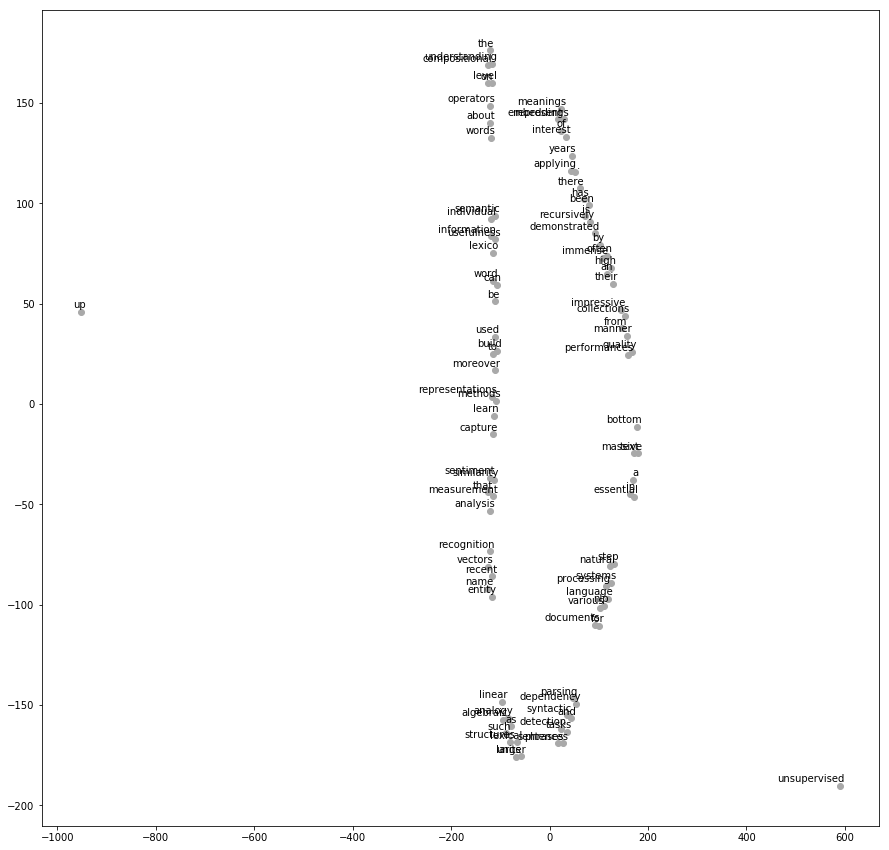

In [14]:
selected_words = ['impressive','words','nlp','sentences']
words = [int2Word[i] for i in np.arange(vocabSize)]
pyplot.figure(figsize=(15,15))
for i, label in enumerate(words):
    x, y = two_d_embeddings[i,:]
    pyplot.scatter(x, y, c='darkgray')   
    if label in listOfAllWordsUnique:
        pyplot.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                       ha='right', va='bottom',fontsize=10)
        
pyplot.show()
